Generate a csv file to use for an AI model for color selection

In [ ]:
import random
import csv
from sklearn.model_selection import train_test_split

def generate_random_color(min_val, max_val):
    return "#{:02x}{:02x}{:02x}".format(
        random.randint(min_val[0], max_val[0]),
        random.randint(min_val[1], max_val[1]),
        random.randint(min_val[2], max_val[2])
    )

def create_dataset(num_samples_per_category):
    # Dictionary with color ranges to be used for classification
    categories = {
        'Black': [(0, 0, 0), (50, 50, 50)],
        'White': [(200, 200, 200), (255, 255, 255)],
        'Dark-Gray': [(50, 50, 50), (100, 100, 100)],
        'Gray': [(100, 100, 100), (150, 150, 150)],
        'Light-Gray': [(150, 150, 150), (200, 200, 200)],
        'Dark-Blue': [(0, 0, 100), (0, 0, 139)],
        'Blue': [(0, 0, 200), (0, 0, 255)],
        'Light-Blue': [(173, 216, 230), (191, 239, 255)],
        'Dark-Brown': [(60, 30, 10), (90, 45, 15)],
        'Brown': [(139, 69, 19), (160, 82, 45)],
        'Cream': [(245, 245, 220), (255, 253, 208)],
        'Dark-Red': [(139, 0, 0), (165, 42, 42)],
        'Red': [(255, 0, 0), (255, 99, 71)],
        'Light-Red': [(255, 160, 122), (255, 182, 193)],
        'Pink': [(255, 182, 193), (255, 192, 203)],
        'Purple': [(128, 0, 128), (160, 32, 240)],
        'Dark-Green': [(0, 100, 0), (0, 128, 0)],
        'Green': [(0, 128, 0), (34, 139, 34)],
        'Light-Green': [(144, 238, 144), (152, 251, 152)],
        'Yellow': [(255, 255, 0), (255, 255, 102)],
        'Orange': [(255, 140, 0), (255, 165, 0)],
        'Peach': [(255, 218, 185), (255, 229, 180)],
        'Gold': [(255, 215, 0), (255, 223, 102)],
    }

    # List to hold all samples
    all_samples = []

    for category, (min_val, max_val) in categories.items():
        # Ensure the RGB values for each color range are valid
        min_val = [min(min_val[i], max_val[i]) for i in range(3)]
        max_val = [max(min_val[i], max_val[i]) for i in range(3)]

        for _ in range(num_samples_per_category):
            hex_color = generate_random_color(min_val, max_val)
            all_samples.append([hex_color, category])

    # Convert to a list for easier manipulation
    all_samples = [(color, category) for color, category in all_samples]

    # Split the dataset into train, validation, and test sets
    train_samples, temp_samples = train_test_split(all_samples, test_size=0.3, random_state=42)  # 70% train
    val_samples, test_samples = train_test_split(temp_samples, test_size=0.5, random_state=42)  # 15% val, 15% test

    # Save to CSV files
    with open('color_dataset_train.csv', 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(['Hex Color', 'Category'])
        writer.writerows(train_samples)

    with open('color_dataset_val.csv', 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(['Hex Color', 'Category'])
        writer.writerows(val_samples)

    with open('color_dataset_test.csv', 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(['Hex Color', 'Category'])
        writer.writerows(test_samples)

# Generate the dataset with splits
create_dataset(1000)


Read the CSV file and convert the Hex colors to RGB that way we can get a testing and training split for an AI model

In [30]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Load the datasets from CSV files
train_data = pd.read_csv('color_dataset_train.csv')
val_data = pd.read_csv('color_dataset_val.csv')
test_data = pd.read_csv('color_dataset_test.csv')

# Convert Hex Color to RGB
def hex_to_rgb(hex_color):
    """Convert a hex color to an RGB tuple."""
    hex_color = hex_color.lstrip('#')
    return tuple(int(hex_color[i:i+2], 16) for i in (0, 2, 4))

# Apply the RGB conversion to the datasets
train_data['RGB'] = train_data['Hex Color'].apply(hex_to_rgb)
val_data['RGB'] = val_data['Hex Color'].apply(hex_to_rgb)
test_data['RGB'] = test_data['Hex Color'].apply(hex_to_rgb)

# Separate features (RGB values) and labels (color category)
X_train = train_data['RGB'].apply(pd.Series)  # Split RGB into separate columns
y_train = train_data['Category']
X_val = val_data['RGB'].apply(pd.Series)      # Split RGB into separate columns
y_val = val_data['Category']
X_test = test_data['RGB'].apply(pd.Series)    # Split RGB into separate columns
y_test = test_data['Category']

# Label encode the color categories
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_val = label_encoder.transform(y_val)  # Use transform for val and test
y_test = label_encoder.transform(y_test)

# Convert to torch tensors
X_train = torch.tensor(X_train.values, dtype=torch.float32)
X_val = torch.tensor(X_val.values, dtype=torch.float32)
X_test = torch.tensor(X_test.values, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
y_val = torch.tensor(y_val, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)

Define our Neural Network architecture and set up the hyperparameters to set up the model

In [44]:
import torch.nn as nn
import torch.optim as optim

class ColorClassifier(nn.Module):
    def __init__(self):
        super(ColorClassifier, self).__init__()
        self.fc1 = nn.Linear(3, 16)  # Input layer (3 RGB values) to hidden layer (16 neurons)
        self.fc2 = nn.Linear(16, 16)  # Hidden layer (16 neurons) to hidden layer (16 neurons)
        self.fc3 = nn.Linear(16, len(label_encoder.classes_))  # Hidden layer to output layer (number of categories)

    def forward(self, x):
        x = torch.relu(self.fc1(x))  # Apply ReLU activation
        x = torch.relu(self.fc2(x))  # Apply ReLU activation
        x = self.fc3(x)               # Output layer (logits)
        return x


# Hyperparameters
learning_rate = 0.00005

# Initialize model, loss function, and optimizer
model = ColorClassifier()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)


Run the AI model

In [45]:
# Training the model
num_epochs = 20000
batch_size = 64

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode

    # Forward pass
    outputs = model(X_train)
    loss = criterion(outputs, y_train)

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Validation phase
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        val_outputs = model(X_val)
        val_loss = criterion(val_outputs, y_val)
        _, val_predicted = torch.max(val_outputs.data, 1)
        val_accuracy = (val_predicted == y_val).sum().item() / y_val.size(0)

    # Print the loss and validation accuracy every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}, Val Accuracy: {val_accuracy * 100:.2f}%')

Epoch [10/20000], Loss: 9.7048, Val Loss: 9.6056, Val Accuracy: 8.99%
Epoch [20/20000], Loss: 9.5005, Val Loss: 9.4006, Val Accuracy: 8.99%
Epoch [30/20000], Loss: 9.3001, Val Loss: 9.1996, Val Accuracy: 8.99%
Epoch [40/20000], Loss: 9.1034, Val Loss: 9.0021, Val Accuracy: 8.99%
Epoch [50/20000], Loss: 8.9027, Val Loss: 8.8005, Val Accuracy: 8.99%
Epoch [60/20000], Loss: 8.7005, Val Loss: 8.5981, Val Accuracy: 8.99%
Epoch [70/20000], Loss: 8.5008, Val Loss: 8.3987, Val Accuracy: 8.99%
Epoch [80/20000], Loss: 8.3013, Val Loss: 8.1995, Val Accuracy: 8.99%
Epoch [90/20000], Loss: 8.1100, Val Loss: 8.0088, Val Accuracy: 8.99%
Epoch [100/20000], Loss: 7.9273, Val Loss: 7.8266, Val Accuracy: 8.96%
Epoch [110/20000], Loss: 7.7515, Val Loss: 7.6510, Val Accuracy: 8.96%
Epoch [120/20000], Loss: 7.5833, Val Loss: 7.4831, Val Accuracy: 9.13%
Epoch [130/20000], Loss: 7.4222, Val Loss: 7.3220, Val Accuracy: 9.30%
Epoch [140/20000], Loss: 7.2642, Val Loss: 7.1633, Val Accuracy: 9.30%
Epoch [150/2000

Check the model accuracy

In [46]:
# Testing the model
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    test_outputs = model(X_test)
    _, test_predicted = torch.max(test_outputs.data, 1)
    test_accuracy = (test_predicted == y_test).sum().item() / y_test.size(0)
    print(f'Test Accuracy: {test_accuracy * 100:.2f}%')


Test Accuracy: 99.57%


Save the model to be used

In [47]:
# Save the trained model
# After training your model
# Save the trained model
import torch
import joblib  

# Save the model weights
torch.save(model.state_dict(), 'color_classifier_model_v3.pth')

# Save the label encoder
joblib.dump(label_encoder, 'label_encoder_v3.pkl')

print("Model and label encoder saved successfully.")


Model and label encoder saved successfully.


In [48]:
# Load the label encoder
label_encoder = joblib.load('label_encoder_v3.pkl')

# Recreate the model architecture
model = ColorClassifier()

# Load the model weights
model.load_state_dict(torch.load('color_classifier_model_v3.pth'))

# Set the model to evaluation mode
model.eval()

print("Model and label encoder loaded successfully.")


Model and label encoder loaded successfully.


C:\Users\Aiden\AppData\Local\Temp\ipykernel_1976\4116434005.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('color_classifier_model_v3.p

Create a simple predicitive model

In [50]:
import torch
import joblib
import torch.nn as nn

# Load the label encoder
label_encoder = joblib.load('label_encoder_v3.pkl')

# Define the model architecture
class ColorClassifier(nn.Module):
    def __init__(self):
        super(ColorClassifier, self).__init__()
        self.fc1 = nn.Linear(3, 16)  # Input layer (3 RGB values) to hidden layer (16 neurons)
        self.fc2 = nn.Linear(16, 16)  # Hidden layer (16 neurons) to hidden layer (16 neurons)
        self.fc3 = nn.Linear(16, len(label_encoder.classes_))  # Hidden layer to output layer (number of categories)

    def forward(self, x):
        x = torch.relu(self.fc1(x))  # Apply ReLU activation
        x = torch.relu(self.fc2(x))  # Apply ReLU activation
        x = self.fc3(x)               # Output layer (logits)
        return x

# Initialize the model and load the saved weights
model = ColorClassifier()
model.load_state_dict(torch.load('color_classifier_model_v3.pth'))
model.eval()


C:\Users\Aiden\AppData\Local\Temp\ipykernel_1976\2265166233.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('color_classifier_model_v3.

ColorClassifier(
  (fc1): Linear(in_features=3, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=16, bias=True)
  (fc3): Linear(in_features=16, out_features=23, bias=True)
)

Accuracy: 0.9957


<Figure size 1000x1000 with 0 Axes>

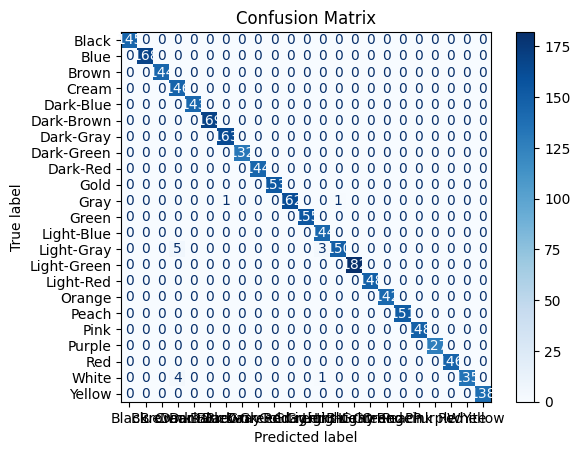

In [55]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import matplotlib.pyplot as plt

test_data = pd.read_csv('color_dataset_test.csv')

# Prepare inputs and true labels
test_inputs = torch.tensor(test_data['Hex Color'].apply(lambda x: np.array([int(x[i:i+2], 16) for i in (1, 3, 5)])).tolist(), dtype=torch.float32)
true_labels = test_data['Category'].values

# Predict using the model
with torch.no_grad():
    outputs = model(test_inputs)

# Get predicted classes
predicted_classes = torch.argmax(outputs, dim=1).numpy()
predicted_labels = label_encoder.inverse_transform(predicted_classes)
accuracy = accuracy_score(true_labels, predicted_labels)
print(f'Accuracy: {accuracy:.4f}')

# Create confusion matrix
cm = confusion_matrix(true_labels, predicted_labels, labels=label_encoder.classes_)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)

# Plot confusion matrix
plt.figure(figsize=(10, 10))
cm_display.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()